<a href="https://colab.research.google.com/github/Austin795/Barcode-Computer-Imaging-Project/blob/master/Barcode_Computer_Imaging_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original image in grayscale for comparison:


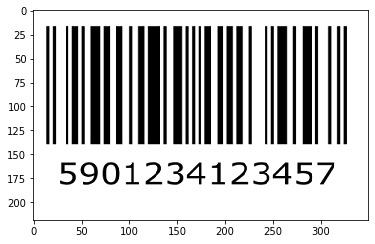

Image seems to be a digital scan. Going to binarize without cleaning up
DETECTED CONTOURS


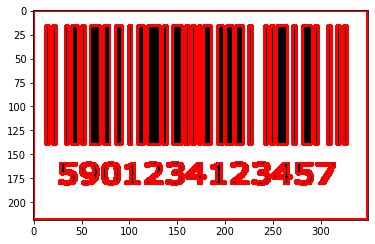

DETECTED BARCODE REGION


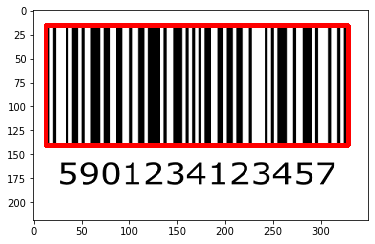

BINARY


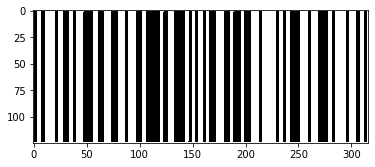

EROSION


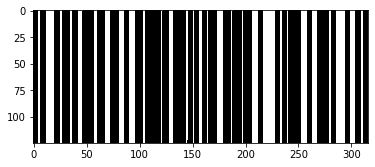

FINAL EDGE DETECTION IMAGE USED FOR ANALYSIS (Binary - Erosion)


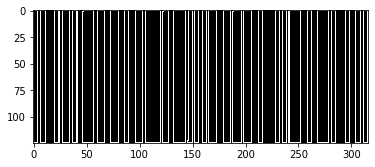

In [0]:
# binarizes the image and does some cropping, uses erosion for edge detection. Does not analyze the bars

from PIL import Image, ImageFilter, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt
import cv2

# General Approach and Methods:
## Binarize the image, increase / decrease contrast, increase / decrease brightness
## shape detection
## use the above shape detection to 'estimate' width value


# binarizeImg takes in an image and converts it to binary using a passed in threshold
def binarizeImg(thresh, baseImg, basePix): 
  newImg = Image.new('L', (baseImg.width, baseImg.height)) # make a copy as to not change our original image
  newPix = newImg.load()
  npArray = np.asarray(newImg)
  for i in range(baseImg.width):
    for j in range(baseImg.height):
      newPix[i, j] = basePix[i, j] # copy our image

  for i in range(newImg.width):
    for j in range(newImg.height):
      if newPix[i, j] < thresh: # check against the threshold value
        newPix[i, j] = 0
      else:
        newPix[i, j] = 1
  return newImg

# function that increases the contrast of an image given an intensity
def adjustContrast(baseImg, intensity):
  contrast = ImageEnhance.Contrast(baseImg)
  contrast = contrast.enhance(intensity) # set FACTOR > 1 to enhance contrast, < 1 to decrease
  return contrast

# using a modifier, returns an image with a changed brightness setting
def adjustBrightness(baseImg, modifier):
  pixels = baseImg.load()
  for i in range(baseImg.width):
    for j in range(baseImg.height):
      newValue = pixels[i, j] + modifier
      if newValue > 255:
        pixels[i, j] = 255
      elif newValue < 0:
        pixels[i, j] = 0
      else:
        pixels[i, j] = newValue
  
  return baseImg

# calculates the min and max pxiels in an image, uses the difference to
# determine whether the quality of the image is good or poor
def imgIsGood(img, thresh):
  npArray = np.asarray(img) # convert to numoy array for easier calculation
  min = np.amin(npArray) # get the minimum pixel value
  max = np.amax(npArray) # get the maximum pixel value

  if min == 0 and max == 255: # if both min and max is 0 and 255, probably a digital barcode image
    return True
  else: # otherwise likely a photo of a bracode
    if (max - min) > thresh:
      return False
    else:
      return True

# SMOOTH AND SHARPEN KERNELS GRABBED FROM: https://www.taylorpetrick.com/blog/post/convolution-part3
def smoothImage(img):
  kernel = np.ones((4,4),np.float32)/25 # smooth kernel
  adjusted = cv2.filter2D(np.asarray(img),-1,kernel)
  return Image.fromarray(adjusted)

def sharpenImage(img):
  kernel = np.array(([0, -1, 0],[-1, 5, -1],[0, -1, 0]), dtype="int")
  adjusted = cv2.filter2D(np.asarray(img),-1,kernel)
  return Image.fromarray(adjusted)

def rotateImage(image, angle):
  imageCenter = tuple(np.array(image.shape[1::-1]) / 2)
  rotationMatrix = cv2.getRotationMatrix2D(imageCenter, angle, 1.0)
  result = cv2.warpAffine(image, rotationMatrix, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

def detectBarCode(origImg, binImg):
  # finds all of the contours of the image of all detected shapes
  contours, _ = cv2.findContours(binImg,1,2)
  img = binImg # copy our binImg into a new variable to not change the original binarized version
  validBar = [] # valid bar consists of the coordinates of all rectangles detected if it is assumed to be a bar in the barcode
  maxAngle = 0
  for cnt in contours:
    (x, y, w, h) = cv2.boundingRect(cnt) # gets the x, y coords and size of the contour
    approx = cv2.approxPolyDP(cnt,0.01*cv2.arcLength(cnt,True),True)
    if len(approx)==4: # if approx is 4, this contour is a rectangle / square
      
      # with x and y > 0, skip the edge of the image being considered a contour.
      # h and w calculations help assure that we only grab contours that are rectangles
      # in the barcode and not from anywhere else in the image
      if x > 0 and y > 0 and h > 30 and w < 70:
        # If all above are true, then this is probably a barcode rectangle. Add it as a valid contour.
        rotatedRect = cv2.minAreaRect(cnt)
        validBar.append((x, y, x + w, y + h))
        angle = rotatedRect[2] * -1 # stores the angle of the contour
        if angle > maxAngle and angle != -90 and angle != 0:
          maxAngle = angle 

  validNp = np.asarray(validBar) # make validBars into a numpy array
  left = np.min(validNp[:,0])
  top = np.min(validNp[:,1])
  right = np.max(validNp[:,2])
  bottom = np.max(validNp[:,3])

  drawBoundingBox(np.asarray(origImg), contours, (left, top, right, bottom))
  rotated = rotateImage(binImg, (maxAngle * -1) // 2) # use our maxAngle // 2 as the amount to rotate

  # convert to pillow image for simple cropping, then return back the numpy array value of the cropped image
  image = Image.fromarray(rotated)
  image = image.crop((left, top, right, bottom))
  return np.asarray(image) 

def drawBoundingBox(image, contours, points):
  # following gets coordinates needed for cropping
  rectImage = np.asarray(image.copy())
  contImage = np.asarray(image.copy())

  cv2.drawContours(contImage, contours, -1, (255, 0, 0), 2)
  print("DETECTED CONTOURS")
  plt.imshow(contImage)
  plt.show()
  
  cv2.rectangle(rectImage, (points[0], points[1]), (points[2], points[3]), (255, 0, 0), 3)
  print("DETECTED BARCODE REGION")
  plt.imshow(rectImage)
  plt.show()

#### BEGIN MAIN ####

# load the barcode
imOrig = Image.open('bar1_resize.jpg')
im = imOrig.convert('L') # convert to grayscale

print("Original image in grayscale for comparison:")
plt.imshow(im, cmap="gray")
plt.show()

erosionFactor = 0 # will change based on whether it is a photo or digital scan
# if image is not a digital scan of a barcode, meaning it is probably a photo, perform some cleanup.
if not imgIsGood(im, 50):
  print("This image seems to be a photo of a barcode, attempting to clean up and binarize.")
  im = adjustBrightness(im, -30) # increasing brightness seems to make fabrizzio's picture worse
  im = adjustContrast(im, -100)
  #im = smoothImage(im)
  im = sharpenImage(im)
  erosionFactor = 6
else:
  print("Image seems to be a digital scan. Going to binarize without cleaning up")
  erosionFactor = 3

# convert the image to binary, im will now hold the binarized pixels
im = binarizeImg(127, im, im.load())

# store im as a numpy array, makes it easier to perform operations
npBin = np.asarray(im)
# attempt to draw and crop the image to where the barcode is
npBin = detectBarCode(imOrig, npBin)

# build a convolution kernel, and use it to generate the difference between the image and its eroded version
kernel = np.ones((erosionFactor, erosionFactor),np.uint8)
erosion = cv2.erode(npBin, kernel)
print("BINARY")
plt.imshow(npBin, cmap='gray', vmin=0,vmax=1)
plt.show()
print("EROSION")
plt.imshow(erosion, cmap='gray', vmin=0,vmax=1)
plt.show()

difference = npBin - erosion # use erosion for edge detection

## Save our final image to be used for analysis
imNewFromArray = Image.fromarray(difference)
imNewFromArray.save('test.png')

print("FINAL EDGE DETECTION IMAGE USED FOR ANALYSIS (Binary - Erosion)")
plt.imshow(difference, cmap='gray', vmin=0,vmax=1)
plt.show()

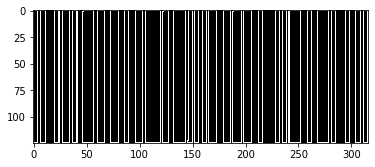

Line number we are reading: 62
1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1  
Raw Data Above ------------- Proccesed Data Below
 
List of widths: [0, 3, 2, 3, 8, 3, 2, 6, 2, 3, 4, 10, 2, 6, 5, 6, 5, 3, 5, 6, 2, 13, 1, 4, 4, 10, 2, 3, 1, 3, 2, 3, 1, 7, 5, 6, 1, 7, 1, 7, 5, 3, 11, 3, 2, 3, 1, 10, 5, 3, 5, 9, 2, 3, 8, 3, 5, 3, 2, 3]


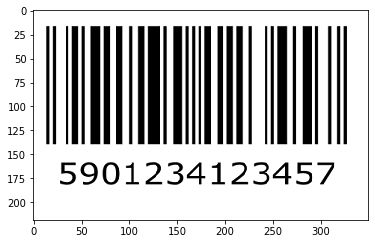

-----------
Black Bar Widths (Even Values) List: [3, 3, 3, 6, 3, 10, 6, 6, 3, 6, 13, 4, 10, 3, 3, 3, 7, 6, 7, 7, 3, 3, 3, 10, 3, 9, 3, 3, 3, 3]
-----------
White Bar Widths (Odd Values) List: [0, 2, 8, 2, 2, 4, 2, 5, 5, 5, 2, 1, 4, 2, 1, 2, 1, 5, 1, 1, 5, 11, 2, 1, 5, 5, 2, 8, 5, 2]
-----------
Visual representation of the line we are reading


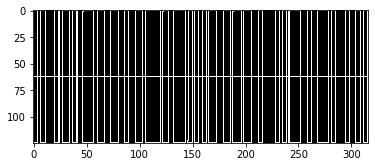

Most Common Values (Widths in Barcode): [3, 6, 7, 10]
Predicted barcode value using our algo: [8, 8, 2, 4, 2, 2, 2, 4, 8, 8, 3, 2, 3, 3, 8, 8, 4, 8, 8]


In [0]:
### Analyzes the bars.  Uses previously binarized image.  Determines number of black pixels and white pixels in one row.
from PIL import Image, ImageDraw
import numpy as np
# Open Binary Image of Barcode from previous method and display it for error check
BinBarcode = Image.open('test.png')
plt.imshow(BinBarcode, cmap='gray', vmin=0,vmax=1)
plt.show()

# What row in the image do we want to read.  We read the middle line (row) with this value
lineNum = BinBarcode.height // 2
print("Line number we are reading:", lineNum)

# Get width of image
width = BinBarcode.width
height = BinBarcode.height

# Return entire image as a numpy 2D array and assign
BBArray = BinBarcode.getdata()

pixels = BinBarcode.load()

#Print the selected row of the image in binary
for i in range (0,width):
  pixels[i,lineNum]
  print(pixels[i,lineNum], end = " ")

# Print the first row of the 2D array.  0 means black pixel found. 1 means white pixel found.
# Collect number of series of 1's 
newList = []
counter = 0

for i in range(0,width):
  if pixels[i,lineNum] == 0:
    counter = counter+1 
  if pixels[i,lineNum] == 1:
    newList.append(counter)
    counter = 0
newList[0] = 0  # set first value to 0 cause it doesn't matter

print(" ")
print("Raw Data Above ------------- Proccesed Data Below")
print(" ")
print("List of widths:", newList)


evenList = []
oddList = []

for i in range(0,len(newList)):
  if i % 2:
    evenList.append(newList[i])
  else:
    oddList.append(newList[i])

barcodeEx = Image.open('barcode.jpg')
plt.imshow(barcodeEx, cmap='gray',vmin=0,vmax=255)
plt.show()

print("-----------")
print("Black Bar Widths (Even Values) List:", evenList)
print("-----------")
print("White Bar Widths (Odd Values) List:", oddList)
print("-----------")
print("Visual representation of the line we are reading")

# draw line (debugging purposes)
pixel = BinBarcode.load()
for i in range (0,width):
  pixel[i,lineNum] = 160
plt.imshow(BinBarcode, cmap='gray', vmin=0,vmax=1)
plt.show()

# Interpet Data found
arr = np.array(evenList)
commonVals = [0,0,0,0]
finalCode = []
currentHigh1 = 0
currentHigh2 = 0
currentHigh3 = 0
currentHigh4 = 0

# Find 4 most common values (widths) in barcode.
for i in range(0,np.amax(arr)):
  check = np.count_nonzero(arr == i)
  if check > currentHigh1:
     currentHigh1 = check
     commonVals[0] = i
  elif check > currentHigh2:
    currentHigh2 = check
    commonVals[1] = i
  elif check > currentHigh3:
    currentHigh3 = check
    commonVals[2] = i
  elif check > currentHigh4:
    currentHigh4 = check
    commonVals[3] = i

# Our simple algo for determining final numeric value hiding in the barcode.  Could be more complex but its just for fun
for i in range(0,len(evenList)):
  if evenList[i] == commonVals[0]:
    # finalCode.append(1)
    if i < len(evenList)-2 and evenList[i+1] == commonVals[0]:
      if evenList[i+1] == commonVals[0]:
        finalCode.append(8)
  if evenList[i] == commonVals[1]:
    finalCode.append(2)
  if evenList[i] == commonVals[2]:
    finalCode.append(3)
  if evenList[i] == commonVals[3]:
    finalCode.append(4)
  
# Do some final prints
print("Most Common Values (Widths in Barcode):", commonVals)
#print(evenList)
#print("Before parse barcode value:", evenList)
print("Predicted barcode value using our algo:", finalCode) 




In [0]:
# Use found widths to turn out some numeric value
# Wherever we get a 0 width its considered an error.  The first value is set to zero cause it doesn't matter.
# Any other zero width values are due to edges meshing produce thick white lines




